In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
import pickle

In [38]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

In [39]:
df = pd.read_csv('dataset.csv')
df.sample(5)

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,...,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
3,615,1,2.5,0,0,0,10,0.8,131,6,...,1216,1786,2769,16,8,11,1,0,0,2
1535,600,1,1.8,0,9,1,6,0.8,199,2,...,486,1032,3495,17,4,7,1,1,0,2
1931,1854,0,0.9,1,0,1,33,0.4,195,1,...,665,718,1675,14,12,9,1,0,1,1
1777,843,0,1.3,1,1,0,16,0.9,119,7,...,593,732,1734,17,8,14,0,0,1,1
1254,1083,0,1.0,0,6,0,52,0.9,126,2,...,925,1469,681,19,18,19,1,1,1,0


In [40]:
df.isnull().sum()

battery_power    0
blue             0
clock_speed      0
dual_sim         0
fc               0
four_g           0
int_memory       0
m_dep            0
mobile_wt        0
n_cores          0
pc               0
px_height        0
px_width         0
ram              0
sc_h             0
sc_w             0
talk_time        0
three_g          0
touch_screen     0
wifi             0
price_range      0
dtype: int64

No data is missing

## Exploratory Data Analysis (EDA)

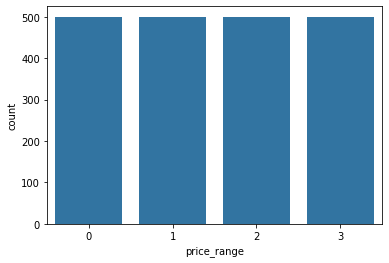

price_range
1    500
2    500
3    500
0    500
Name: count, dtype: int64


In [41]:
# Target variable distribution
sns.countplot(x='price_range', data=df)
plt.show()

print(df['price_range'].value_counts())

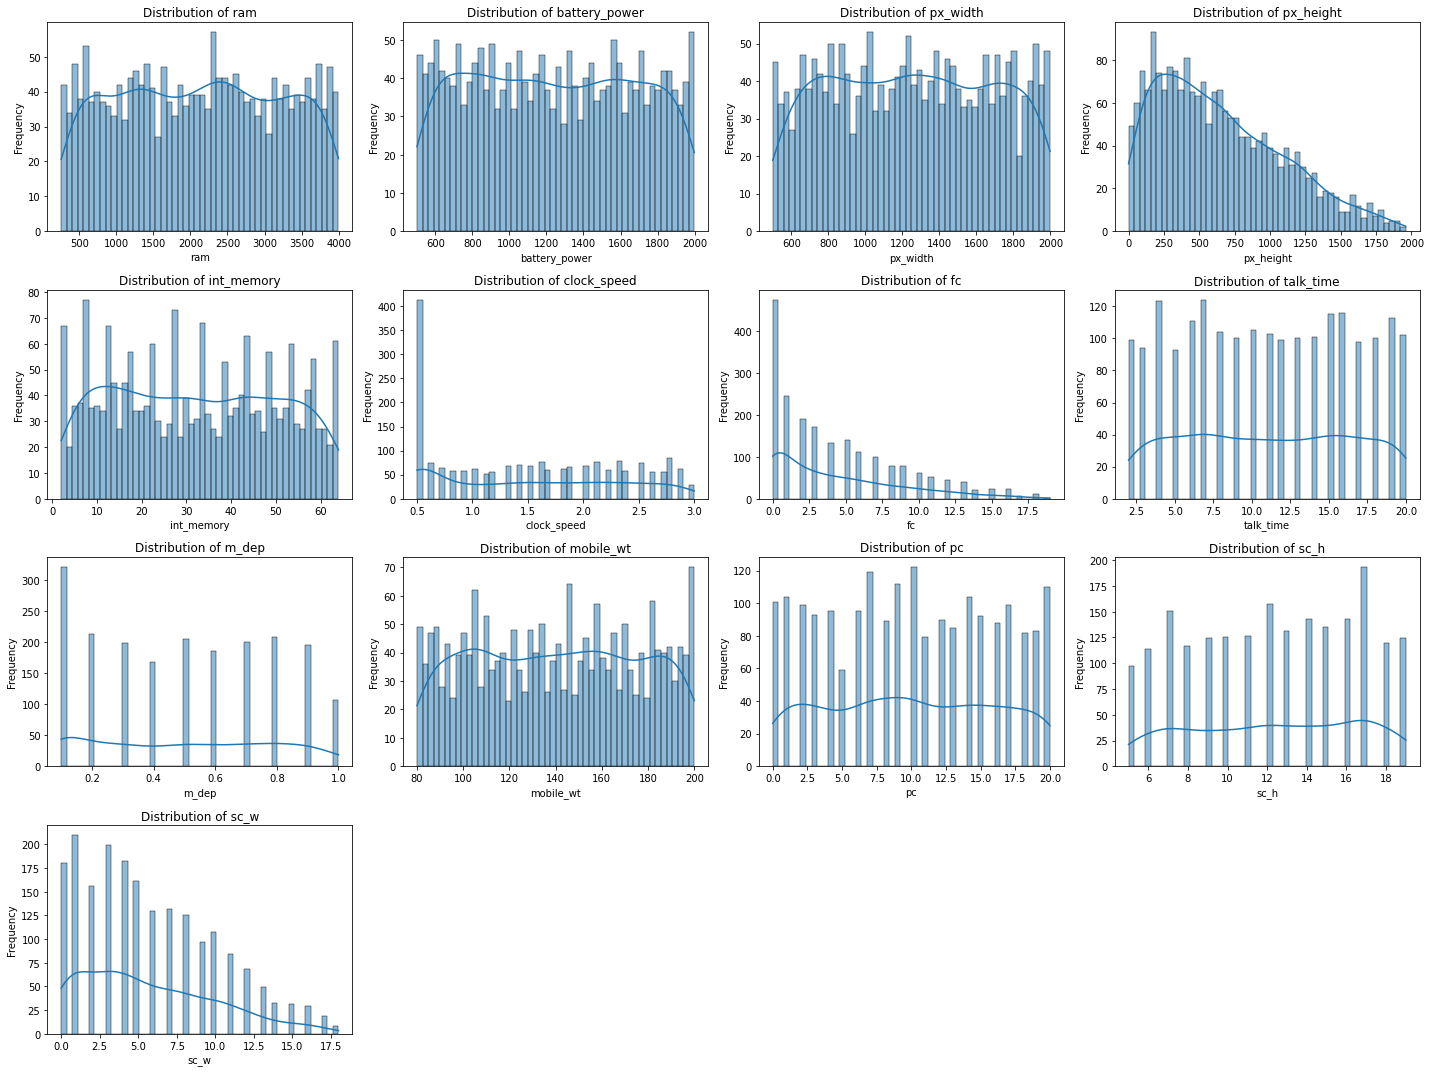

In [42]:
num_features = ['ram' , 'battery_power', 'px_width', 'px_height', 'int_memory', 'clock_speed', 'fc', 'talk_time', 'm_dep', 
                'mobile_wt', 'pc', 'sc_h', 'sc_w']

plt.figure(figsize=(20, 15))

for i, col in enumerate(num_features):
    plt.subplot(4, 4, i + 1)
    sns.histplot(df[col], bins = 50, kde=True)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

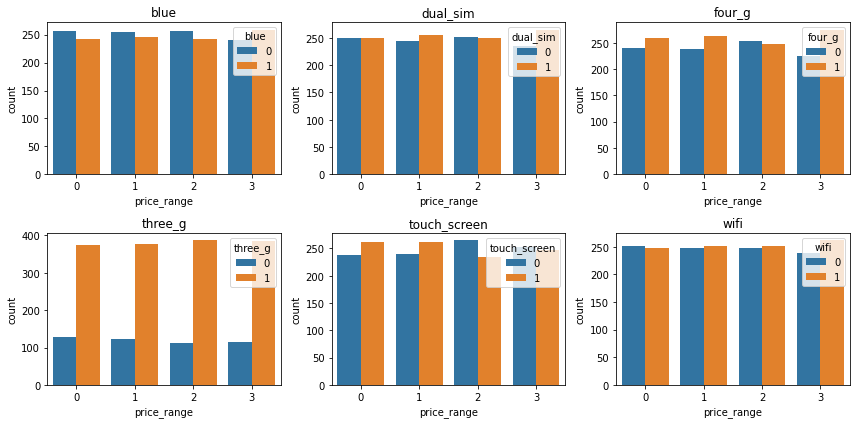

In [43]:
cat_features = ['blue', 'dual_sim', 'four_g', 'three_g', 'touch_screen', 'wifi']
plt.figure(figsize=(12, 6))
for i, feature in enumerate(cat_features, 1):
    plt.subplot(2, 3, i)
    sns.countplot(x='price_range', hue=feature, data=df)
    plt.title('Price Range Distribution by WiFi Availability')
    plt.title(feature)
plt.tight_layout()
plt.show()

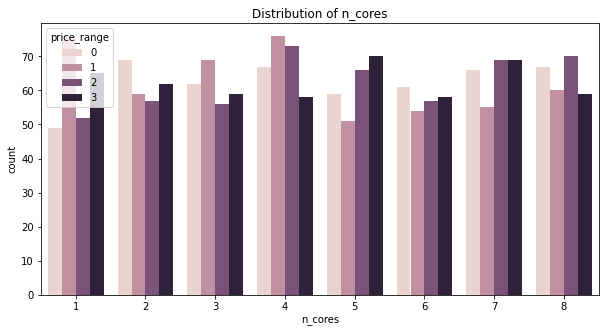

In [44]:
plt.figure(figsize=(10, 5))
sns.countplot(x='n_cores', hue='price_range', data=df)
plt.title('Distribution of n_cores')

plt.show()

## Feature Construction

In [ ]:
df['pixel_density'] = df['px_width'] * df['px_height']
df['screen_area'] = df['sc_h'] * df['sc_w']
df['core_efficiency'] = df['clock_speed'] * df['n_cores']

# Dropping features to avoid multicollinearity
df.drop(columns=['px_width', 'px_height', 'sc_h', 'sc_w', 'clock_speed', 'n_cores' ], inplace=True)

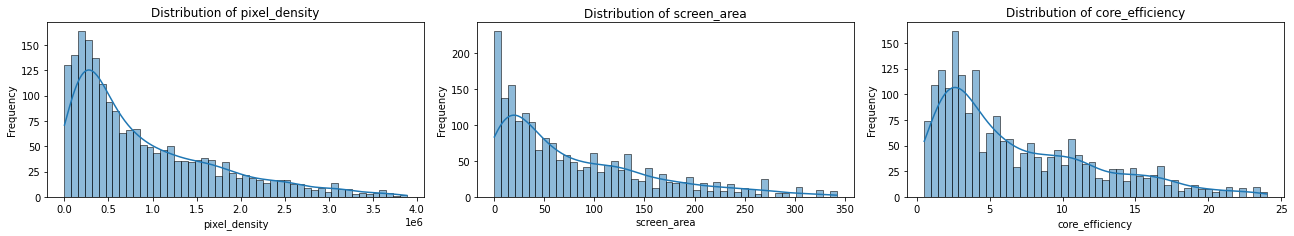

In [46]:
new_features = ['pixel_density', 'screen_area', 'core_efficiency']

plt.figure(figsize=(24, 12))

for i, col in enumerate(new_features):
    plt.subplot(4, 4, i + 1)
    sns.histplot(df[col], bins = 50, kde=True)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

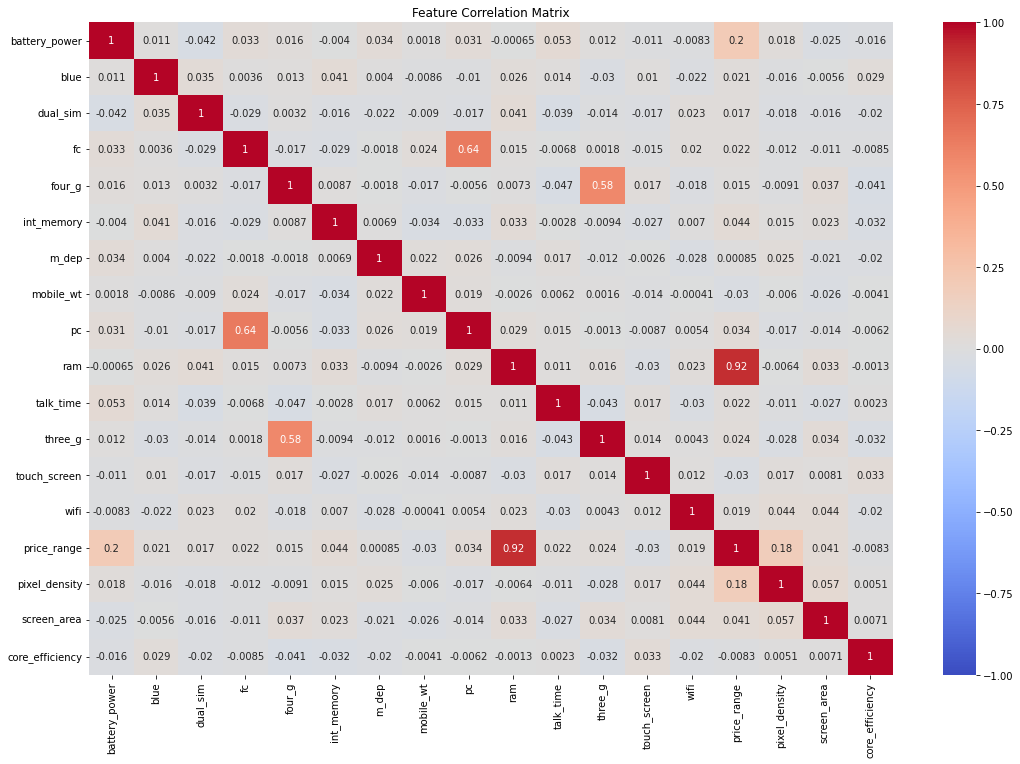


Correlation with target variable:
price_range        1.000000
ram                0.917046
battery_power      0.200723
pixel_density      0.176240
int_memory         0.044435
screen_area        0.041248
pc                 0.033599
three_g            0.023611
fc                 0.021998
talk_time          0.021859
blue               0.020573
wifi               0.018785
dual_sim           0.017444
four_g             0.014772
m_dep              0.000853
core_efficiency   -0.008290
mobile_wt         -0.030302
touch_screen      -0.030411
Name: price_range, dtype: float64


In [47]:
# correlation matrix

corr_matrix = df.corr()

plt.figure(figsize=(18, 12))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, vmin=-1, vmax=1)
plt.title('Feature Correlation Matrix')
plt.show()

# correlations with target
target_corr = corr_matrix['price_range'].sort_values(ascending=False)
print("\nCorrelation with target variable:")
print(target_corr)

In [48]:
df.sample(5)

,battery_power,blue,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,pc,ram,talk_time,three_g,touch_screen,wifi,price_range,pixel_density,screen_area,core_efficiency
157,1224,0,0,16,1,6,0.4,109,18,506,11,1,1,1,0,617022,0,3.0
276,1662,0,0,0,1,61,0.8,126,13,3760,13,1,1,1,3,48288,45,2.0
1957,1589,0,0,0,0,5,0.8,112,2,3430,19,1,1,1,3,1084072,35,3.0
526,535,1,1,8,1,54,0.5,145,15,2674,10,1,0,0,2,666690,112,4.0
1386,610,1,1,9,0,52,0.4,90,19,3472,12,1,1,1,3,1322647,40,6.4


In [ ]:
X_train,X_test,y_train,y_test = train_test_split(df.drop(columns=['price_range']),df['price_range'],test_size=0.2,random_state=42)

In [50]:
X_train.sample(5)

,battery_power,blue,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,pc,ram,talk_time,three_g,touch_screen,wifi,pixel_density,screen_area,core_efficiency
71,1407,1,0,1,1,22,0.7,104,4,2192,13,1,0,1,1426324,63,9.6
1735,753,1,0,11,1,48,0.1,121,20,3484,16,1,0,0,797496,110,4.0
1309,1433,1,0,2,1,5,0.1,129,11,2132,19,1,0,1,329280,270,11.5
1827,1692,0,0,4,1,2,0.9,106,17,3779,7,1,1,1,3615696,27,2.1
1835,1680,1,1,6,1,37,0.7,168,7,1459,2,1,1,0,835849,45,4.8


In [51]:
has_negative = (df < 0).any().any()
has_negative

False

## Data Preprocessing

In [52]:
# Features ['pixel_density', 'screen_area', 'core_efficiency', 'fc'] have right-skewed distribution. 
# Applying Power transform on these features

trf1 = ColumnTransformer([('power_transform', PowerTransformer(method='yeo-johnson'), [3, 14, 15, 16])], remainder='passthrough')

In [53]:
# Standardization
# numerical features : ['battery_power', 'fc', 'int_memory', 'm_dep', 'mobile_wt', 'pc', 'ram', 'talk_time', 'pixel_density', 
#                       'screen_area', 'core_efficiency']

trf2 = ColumnTransformer([('standard_scaler', StandardScaler(), [0, 3, 5, 6, 7, 8, 9, 10, 14, 15, 16])], remainder='passthrough')

In [ ]:
# Selecting top k features using ANOVA F-value
trf3 = SelectKBest(score_func=f_classif, k=10) 

In [55]:
# Applying Random Forest Classifier
trf4 = RandomForestClassifier(n_estimators=100, random_state=42)

In [ ]:
pipe = Pipeline([
    ('power_transform', trf1),            
    ('standard_scaler', trf2),            
    ('select_k_best', trf3),              
    ('classifier', trf4)                 
])

In [57]:
pipe.fit(X_train,y_train)

Pipeline(steps=[('power_transform',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('power_transform',
                                                  PowerTransformer(),
                                                  [3, 14, 15, 16])])),
                ('standard_scaler',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('standard_scaler',
                                                  StandardScaler(),
                                                  [0, 3, 5, 6, 7, 8, 9, 10, 14,
                                                   15, 16])])),
                ('select_k_best', SelectKBest()),
                ('classifier', RandomForestClassifier(random_state=42))])

Accuracy: 0.895
Precision: 0.896461854576788
Recall: 0.895
F1 Score: 0.8953660081262029


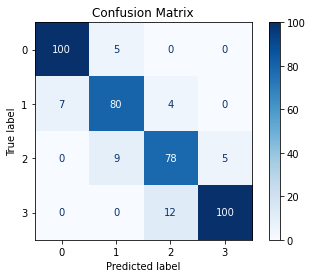

In [58]:
y_pred = pipe.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred, average='weighted'))
print("Recall:", recall_score(y_test, y_pred, average='weighted'))
print("F1 Score:", f1_score(y_test, y_pred, average='weighted'))

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipe.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

In [59]:
cv_scores = cross_val_score(pipe, X_train, y_train, cv=5, scoring='accuracy')

print("Cross-validation scores:", cv_scores)
print("Mean CV Accuracy:", cv_scores.mean())
print("Standard deviation:", cv_scores.std())

Cross-validation scores: [0.88125  0.915625 0.8875   0.86875  0.86875 ]
Mean CV Accuracy: 0.884375
Standard deviation: 0.017230060940112774


In [ ]:
# Finding K best Selected features after feature selection

selector = pipe.named_steps['select_k_best']
selected_indices = selector.get_support(indices=True)
X_train.columns[selected_indices]

Index(['blue', 'int_memory', 'm_dep', 'mobile_wt', 'ram', 'three_g',
       'touch_screen', 'wifi', 'screen_area', 'core_efficiency'],
      dtype='object')

## Saving Trained Model

In [61]:
with open('model.pkl', 'wb') as f:
    pickle.dump(pipe, f)